In [7]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import MLPComponentsCV
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, AIC_OLS, RSS

# helper functions
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

def to_numpy(x):
    return x.detach().cpu().numpy()

In [8]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
population = 50000
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
n_runs = 1000
chi_type = 'piecewise'
case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

Device set to cpu


In [9]:
params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)

In [10]:
data = np.array(params['data'])
data_smooth = np.mean(data, axis=0)
data_smooth = (data_smooth / params['population'])

N = len(data_smooth) - 2
u = to_torch(data_smooth[1:N+1,:])

t_max_real = N
t = np.arange(N)[:,None] + 1
params.pop('data')

u_front = data_smooth[:N,:]
u_back = data_smooth[2:,:]
ut = to_torch((u_back - u_front) / 2.)

# split into train/val and convert to torch
split = int(0.8*N)
# generate shuffled array of indices from 0 to N-1
p = np.random.permutation(N)[:,None]

u_tensor = torch.cat([u[:,:,None], ut[:,:,None]], axis=2)

x_train = to_torch((p[:split] + 1))
# assign y_train to be values corresponding to x_train of size int(0.8 * N)
y_train = to_torch(u[(p[:split]).flatten()])
# assign x_val to be randomly shuffled days from 1 to 182 of size int(0.2 * N)
x_val = to_torch((p[split:] + 1))
# assign y_val to be values corresponding to y_val of size int(0.2 * N)
y_val = to_torch(u[(p[split:]).flatten()])

tracing_array = params['tracing_array']

C:\Users\Teddy\AppData\Local\Temp\ipykernel_15248\4090372697.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = torch.tensor(ndarray, dtype=torch.float)


In [11]:
# mydir = '../models/covasim/debugging/2023-06-30_10-07-13'
mydir = '../models/covasim/debugging/2023-06-30_11-47-15'

binn = MLPComponentsCV(params, u_tensor, N, tracing_array, keep_d=keep_d, chi_type=chi_type).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [12]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data_smooth[0, :].copy()

In [13]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [14]:
# simulate PDE. First grab the parameter values from the loaded BINN model.
params['yita_lb'] = model.model.yita_lb
params['yita_ub'] = model.model.yita_ub
params['beta_lb'] = model.model.beta_lb
params['beta_ub'] = model.model.beta_ub
params['tau_lb'] = model.model.tau_lb
params['tau_ub'] = model.model.tau_ub

In [15]:
# if D is to be included in the model, otherwise use the other solver.
if keep_d:
    RHS = PDESolver.STEAYDQRF_RHS_dynamic
    u_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate, beta, tau, params, chi_type)
    u_sim_NN *= population

c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([ds, dt, de, da, dy, dd, dq, dr, df])


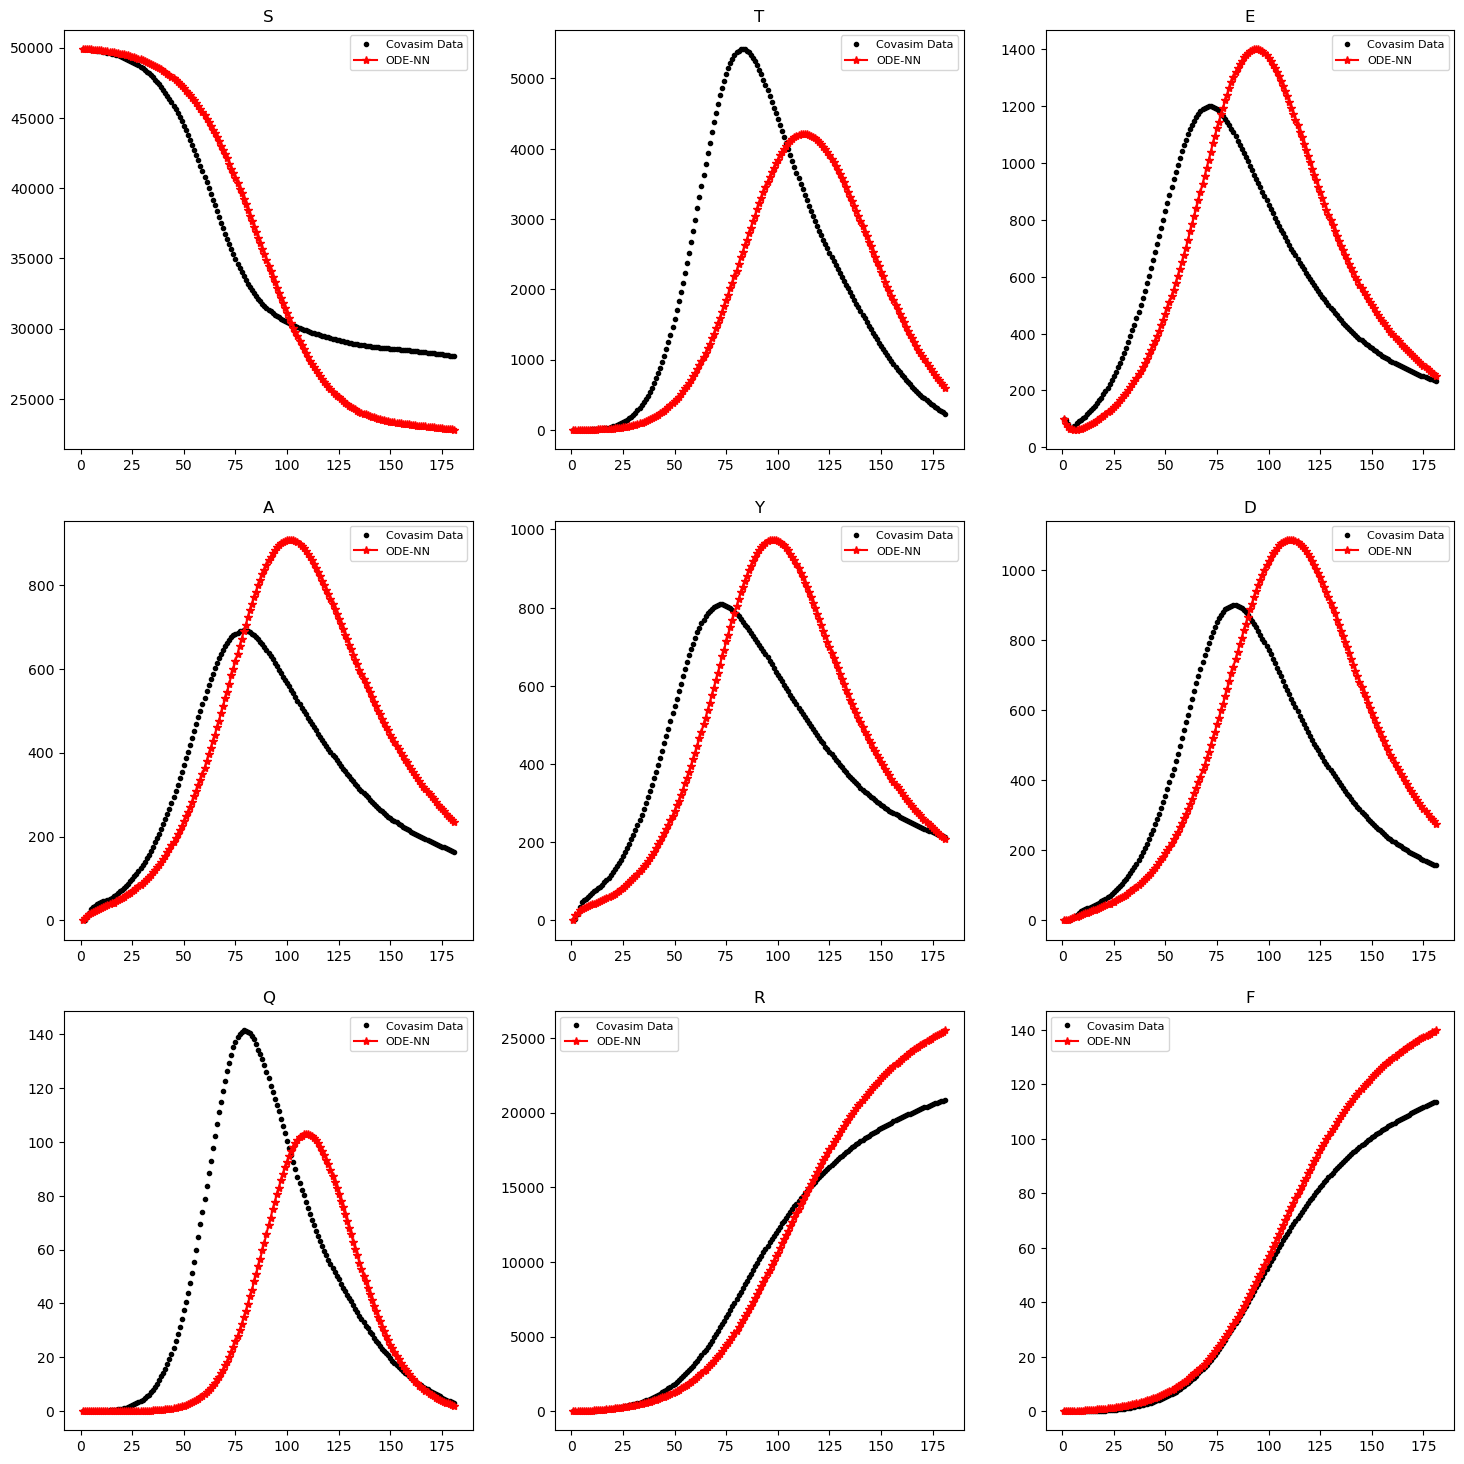

In [27]:
# rescale data values to represent number of people in state X rather than ratios
data *= population

plot=True
if plot:
    n = data_smooth.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # t = np.arange(1, data.shape[0] + 1)
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, data_smooth[1:N+1, i - 1] * population, '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '.png') )
        # plt.show()